In [165]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter1d
import pickle
from scipy.spatial.distance import cdist
from scipy.special import iv

# Define functions and classes

In [163]:
class trajectory:
    def __init__(self, position):
        self.position = position
    def append(self,position):
        self.position = np.vstack((self.position,position))
    def lastPos(self,howFarInTime):
        if self.position.shape==(2,):
            return self.position
        elif howFarInTime==1:
            return self.position[-howFarInTime:][0]
        else:
            return self.position[-howFarInTime:]
        
def dist(a,b):
    return np.linalg.norm(a-b)
def vector(a,b):
    return [b[0]-a[0],b[1]-a[1]]

def discrete1D1O_gaussiankernel(radius, sigma,standardised=True):
    """First order 1-dimensional, discrete gaussian kernel. Requires scipy.special.iv

    Args:
        radius (int): radius of the window. 
        sigma (float): sigma of the kernel
        standardised (bool, optional): Whether values are standardised (see Mathematica's GaussianMatrix). Defaults to True.
    Returns:
        np.array: kernel
    """    
    window = np.arange(-radius-1,radius+2)
    T = np.exp(-sigma**2) * iv(window, sigma**2)
    out = np.convolve([.5,0,-.5],T,mode='valid')
    if not standardised:
        return out
    else:
        out -= np.mean(out)
        val = -np.dot(out,np.arange(-int((len(out))/2),int((len(out)+1)/2)))
        return out/val
    
def smooth1der(y,radius, sigma,standardised=True,spacing=1):
    """Returns convolution of a discrete first order gaussian kernel to calculate a smoothened first derivative. 

    Args:
        y (np.array): array to be derived and smoothened
        radius (int): radius of the window. 
        sigma (float): sigma of the kernel
        standardised (bool, optional): Whether values are standardised (see Mathematica's GaussianMatrix). Defaults to True.
        spacing (int, optional): spacing between values of y. Defaults to 1.

    Returns:
        np.array: smooth 1st derivative of y
    """    
    return np.convolve(y,discrete1D1O_gaussiankernel(radius,sigma,standardised)/spacing,mode='valid')

# Try one

In [ ]:
homedir = '/Volumes/PIV data - Edoardo/thickSheet4PTV/'
savedir = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/'
directories = glob.glob(homedir+'Cam*')
directory = directories[9]+'/'

imagesDir = []
for imageDir in glob.glob(directory+'*.tif'):
    imagesDir.append(imageDir)
imagesDir = np.sort(imagesDir)

# TEST
testImg = rgb2gray(cv2.imread(imagesDir[0])[200:800,:])
print(np.max(testImg))
testImg /= np.max(testImg)
testImg = np.where(testImg>0.20,testImg,0)
plt.figure(figsize=(10,16))
plt.imshow(testImg,cmap='Greys_r')
# detect peaks
peaks = peak_local_max(testImg,min_distance=4)
for peak in peaks:
    plt.scatter(peak[1],peak[0],color='red',marker='x')
plt.title('test')
plt.show()

# Read all particles

In [ ]:
pos_t = []
for imageDir in imagesDir[::]:
    image = rgb2gray(cv2.imread(imageDir)[200:800,:])
    # image = rgb2gray(cv2.imread(imageDir)[400:500,225:275])
    image /= 0.03529411764705882
    image = np.where(image>0.20,image,0)
    peaks = peak_local_max(image,min_distance=4)
    pos_t.append(peaks)
    # print(imageDir)

## Print a few to check

In [ ]:
plt.figure(dpi=150)
myColors = np.tile(['tab:blue','tab:orange','purple','green','red'],20)
for ip,peaks in enumerate(pos_t[:]):
    plt.scatter(peaks[:,1],peaks[:,0],color=myColors[ip])
    # for txt in peaks:
    #     plt.text(txt[1],txt[0],f'{ip}')
plt.gca().invert_yaxis()
plt.grid()
# plt.ylim(400,500)
# plt.xlim(200,400)
plt.gca().set_aspect('equal')
plt.show()

# Find trajectories

In [ ]:
import quads
centre = list(np.array(testImg.shape)/2)
xspan = testImg.shape[1]
yspan = testImg.shape[0]
tree = quads.QuadTree(centre, yspan, xspan)

trajectories = []
distanceThreshold = 3 # how far can points be to be accepted

for time,particlesInFrame in enumerate(pos_t[:]): # loop over frames
    currentTree = quads.QuadTree(centre, yspan+1, xspan+1) # this is the tree at the current iteration
    # plt.scatter(pos_t[time][:,1],pos_t[time][:,0],c='green',marker='x',s=100)
    # for txt in pos_t[time]:
    #     plt.text(txt[1],txt[0],f'{time}')
    ##### INITIALIZATION STEPS #
    if time == 0 : # there are no tracks yet, let's add!
        for _,particle in enumerate(particlesInFrame):
            trajectories.append(trajectory(particle))
    if time == 1 : # just add to the trajectory
        for _,particle in enumerate(particlesInFrame):
            currentTree.insert(tuple(particle),data=False)
        for tr in trajectories:
            point_x, point_y = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].x,currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].y
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point_x,point_y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
    ##### INITIALIZATION TERMINATED ##
      
    ##### NOW LET'S EXTEND THE KNOWN TRAJECTORIES ##
    for _,particle in enumerate(particlesInFrame):
        if time <= 1 :break # this was already done in the first two timesteps
        currentTree.insert(tuple(particle))
    for _,tr in enumerate(trajectories):
        if time <= 1 :break # this shouldn't be done in the first two timesteps
        trajLen = tr.position.shape[0]
        if tr.position.shape==(2,): # needs to initialise the second point for recently-started trajectories
            point = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
            continue # I cannot do anything more with one-point trajectories
        if trajLen > 1 and trajLen <= 6 : # not enough datapoints to make a full prediction
            predicted = tr.position[-1] + vector(tr.position[-1],tr.position[-2])
            # plt.scatter(predicted[1],predicted[0],c='k',marker='x',s=100)
            if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
            point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position

        if trajLen > 6 : # can do a full prediction
            fit_y = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,0],2)) # y is the first coordinate
            predicted_y = fit_y(4)
            fit_x = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,1],2)) # x is the second coordinate
            predicted_x = fit_x(4)
            predicted = [predicted_y,predicted_x]
            # plt.scatter(predicted_x,predicted_y,c='k',marker='x')
            # plt.plot(fit_x(np.arange(5)),fit_y(np.arange(5)),c='k',linestyle='--')
            if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
            point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position
    
    # aggiungi tutte le particles che non sono in una traiettoria
    pointsInTree = np.transpose(([point.x for point in currentTree._root.all_points()],[point.y for point in currentTree._root.all_points()]))
    lastPosOfTraj = np.array([list(tr.lastPos(1)) for tr in trajectories])
    for unmatchedPoint in pointsInTree[(pointsInTree[:,None]!=lastPosOfTraj).any(-1).all(1)]: # https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array
        trajectories.append(trajectory(unmatchedPoint))
        # print(time,unmatchedPoint)
    
# for tr in trajectories:
#     if tr.position.shape==(2,): continue
#     plt.plot(tr.position[:,1],tr.position[:,0],marker='o')

'''
NEED TO: 
    - connect tracks that skip
'''

In [ ]:
with open(savedir+f'trajectories_{directory[-40:-1]}', "wb") as fp:   #Pickling
    pickle.dump(trajectories, fp)

In [ ]:
plt.figure(dpi=150)
for tr in loadedTrajectories[:]:
    if tr.position.shape==(2,): continue
    if tr.position.shape[0]<50:continue
    plt.plot(tr.position[:,1],tr.position[:,0])
plt.grid()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
# plt.ylim(400,420)
# plt.xlim(50,75)
plt.show()

# LOOP

In [ ]:
directories = glob.glob(homedir+'Cam*')
from tqdm import tqdm
for directory in tqdm(directories):
    directory += '/'
    imagesDir = []
    for imageDir in glob.glob(directory+'*.tif'):
        imagesDir.append(imageDir)
    imagesDir = np.sort(imagesDir)

    pos_t = []
    for imageDir in imagesDir[::]:
        image = rgb2gray(cv2.imread(imageDir)[200:800,:])
        # image = rgb2gray(cv2.imread(imageDir)[400:500,225:275])
        image /= 0.03529411764705882
        image = np.where(image>0.20,image,0)
        peaks = peak_local_max(image,min_distance=4)
        pos_t.append(peaks)

    centre = list(np.array(testImg.shape)/2)
    xspan = testImg.shape[1]
    yspan = testImg.shape[0]
    tree = quads.QuadTree(centre, yspan, xspan)

    trajectories = []
    distanceThreshold = 3 # how far can points be to be accepted

    for time,particlesInFrame in enumerate(pos_t[:]): # loop over frames
        currentTree = quads.QuadTree(centre, yspan+1, xspan+1) # this is the tree at the current iteration
        # plt.scatter(pos_t[time][:,1],pos_t[time][:,0],c='green',marker='x',s=100)
        # for txt in pos_t[time]:
        #     plt.text(txt[1],txt[0],f'{time}')
        ##### INITIALIZATION STEPS #
        if time == 0 : # there are no tracks yet, let's add!
            for _,particle in enumerate(particlesInFrame):
                trajectories.append(trajectory(particle))
        if time == 1 : # just add to the trajectory
            for _,particle in enumerate(particlesInFrame):
                currentTree.insert(tuple(particle),data=False)
            for tr in trajectories:
                point_x, point_y = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].x,currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].y
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point_x,point_y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
        ##### INITIALIZATION TERMINATED ##
        
        ##### NOW LET'S EXTEND THE KNOWN TRAJECTORIES ##
        for _,particle in enumerate(particlesInFrame):
            if time <= 1 :break # this was already done in the first two timesteps
            currentTree.insert(tuple(particle))
        for _,tr in enumerate(trajectories):
            if time <= 1 :break # this shouldn't be done in the first two timesteps
            trajLen = tr.position.shape[0]
            if tr.position.shape==(2,): # needs to initialise the second point for recently-started trajectories
                point = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
                continue # I cannot do anything more with one-point trajectories
            if trajLen > 1 and trajLen <= 6 : # not enough datapoints to make a full prediction
                predicted = tr.position[-1] + vector(tr.position[-1],tr.position[-2])
                # plt.scatter(predicted[1],predicted[0],c='k',marker='x',s=100)
                if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
                point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position

            if trajLen > 6 : # can do a full prediction
                fit_y = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,0],2)) # y is the first coordinate
                predicted_y = fit_y(4)
                fit_x = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,1],2)) # x is the second coordinate
                predicted_x = fit_x(4)
                predicted = [predicted_y,predicted_x]
                # plt.scatter(predicted_x,predicted_y,c='k',marker='x')
                # plt.plot(fit_x(np.arange(5)),fit_y(np.arange(5)),c='k',linestyle='--')
                if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
                point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position
        
        # aggiungi tutte le particles che non sono in una traiettoria
        pointsInTree = np.transpose(([point.x for point in currentTree._root.all_points()],[point.y for point in currentTree._root.all_points()]))
        lastPosOfTraj = np.array([list(tr.lastPos(1)) for tr in trajectories])
        for unmatchedPoint in pointsInTree[(pointsInTree[:,None]!=lastPosOfTraj).any(-1).all(1)]: # https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array
            trajectories.append(trajectory(unmatchedPoint))

    with open(savedir+f'trajectories_{directory[-40:-1]}', "wb") as fp:   #Pickling
        pickle.dump(trajectories, fp)

# Load looped trajectories 

In [167]:
from itertools import zip_longest

dt = 1 

trajFiles = []

for trajFile in glob.glob('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/trajec*'):
    trajFiles.append(trajFile)

trajFiles = np.sort(trajFiles)
meanYVels = []
meanXVels = []
stdYvels = []

for i_f,trajFile in enumerate(trajFiles[-5:]):
    with open(trajFile, "rb") as fp:   # Unpickling
        loadedTrajectories = pickle.load(fp)
    velocities = np.array([np.nan,np.nan])
    l1=range(13)
    l2=[]
    d1=dict(zip_longest(l1,l2))
    for i,tr in enumerate(loadedTrajectories[:]):
        if tr.position.shape==(2,):continue
        if tr.position.shape[0]<50:continue
        velocities = np.vstack((velocities,np.gradient(tr.position,axis=0)/dt))
        # print(tr.position.shape)
        meanVelAlongTraj = np.mean(np.gradient(tr.position,axis=0)[:,0]/dt) ### IT'S WRONG!! FOR TEST ONLY!!!
        if d1[tr.position[0,1]%13] == None:
            d1[tr.position[0,1]%13] = [meanVelAlongTraj,]
        else:
            d1[tr.position[0,1]%13].append(meanVelAlongTraj)
        if i==100: break
    for key in d1.keys():
        if d1[key] == None:
            d1[key] = np.nan
        else:
            d1[key] = np.nanmean(d1[key])
        
    lists = sorted(d1.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    # plt.plot(x, y)
    # plt.show()

    # meanYVels.append(np.nanmean(velocities[:,0]))
    # meanXVels.append(np.nanmean(velocities[:,1]))
    # stdYvels.append(np.nanstd(velocities[:,0]))
    # nbins = 13

    # plt.figure()
    # plt.hist(velocities[:,0].flatten(),label='y-direction',alpha=0.5,bins=nbins)
    # plt.hist(velocities[:,1].flatten(),label='x-direction',alpha=0.5,bins=nbins)
    # plt.vlines(np.nanmean(velocities[:,0]),1,1e6)
    # plt.title(f'PDF velocity w/ direction {i_f}')
    # plt.xlabel('velocity []')
    # plt.ylabel('PDF []')
    # plt.yscale('log')
    # plt.grid()
    # plt.legend()
    # plt.show()

    # nbins = 3

    # plt.figure()
    # plt.plot(np.mean(velocities,axis=1))
    # plt.show()
    # break

# Get velocities

In [ ]:
dt = 1 # s
velocities = np.array([np.nan,np.nan])

for i,tr in enumerate(loadedTrajectories[:]):
    if tr.position.shape[0]<50:continue
    # if tr.position.shape[0]>100:continue
    velocities = np.vstack((velocities,np.gradient(tr.position,axis=0)/dt))

nbins = 13
plt.hist(velocities[:,0].flatten(),label='y-direction',alpha=0.5,bins=nbins)
plt.hist(velocities[:,1].flatten(),label='x-direction',alpha=0.5,bins=nbins)
plt.vlines(np.nanmean(velocities[:,0]),1,1e6)

plt.title('PDF velocity w/ direction')
plt.xlabel('velocity []')
plt.ylabel('PDF []')
plt.yscale('log')
# plt.xlim(-50,50)
# plt.ylim(1e0,1e5)
plt.grid()
plt.legend()
plt.show()

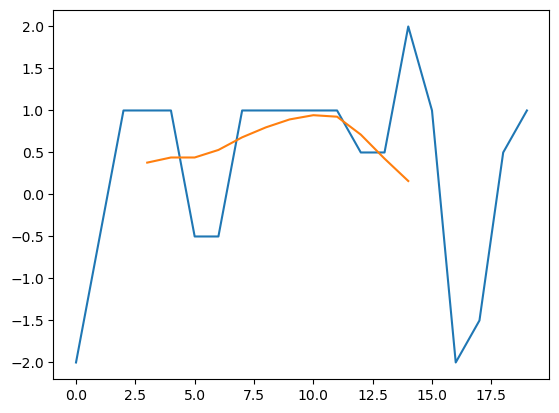

NameError: name 'testVel' is not defined

<Figure size 640x480 with 0 Axes>

In [173]:
testTraj = loadedTrajectories[10]

plt.figure()
plt.plot(np.gradient(testTraj.position[:,0]))
plt.plot(range(3,15),smooth1der(testTraj.position[:,0],4,3,spacing=1))
plt.show()

plt.figure()
plt.scatter(testVel[:,0],testVel[:,1],c=testVel[:,2]/np.max(testVel[:,2]))
plt.show()

# Create convolution funciton

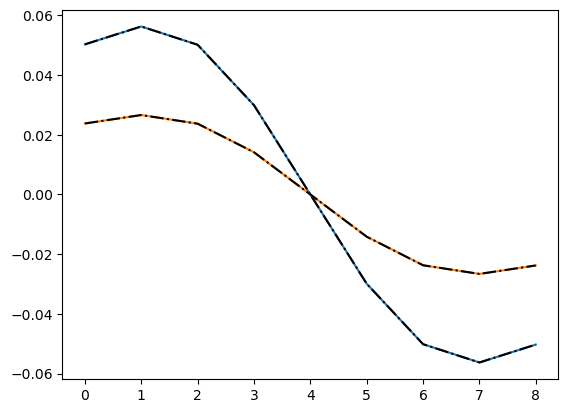

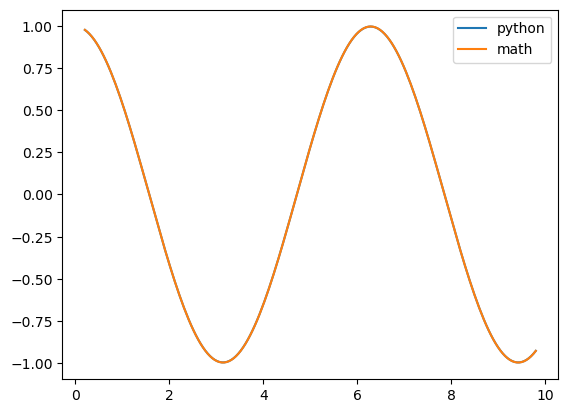

In [164]:
stdmathoutput=[0.0502658, 0.0562571, 0.050136, 0.0298937, 0., -0.0298937, -0.050136, -0.0562571, -0.0502658] # standardised
mathoutput = [0.0237696, 0.0266028, 0.0237083, 0.0141361, 0., -0.0141361, -0.0237083, -0.0266028, -0.0237696] # non standardised
def kernel(windowSize, sigma,spacing=1,standardised=False):
    window = np.arange(-windowSize-1,windowSize+2)
    T = np.exp(-sigma**2) * iv(window, sigma**2)
    out = np.convolve([.5,0,-.5],T,mode='valid')
    if not standardised:
        return out/spacing
    else:
        out -= np.mean(out)
        # val = out . Range[-(Length[out] - 1)/2, (Length[out] - 1)/2]^n /n!
        val = np.dot(out,np.arange(-int((len(out))/2),int((len(out)+1)/2)))
        #val *= (-1)^n
        val *= -1
        return out/(val*spacing)
x = np.linspace(0,10,200)
plt.plot(kernel(4,3,standardised=True),c='tab:blue')
plt.plot(stdmathoutput,c='k',linestyle='-.')
plt.plot(kernel(4,3,standardised=0),c='tab:orange')
plt.plot(mathoutput,c='k',linestyle='-.')
plt.show()

y = np.sin(x)
# plt.plot(x[4:-4],np.convolve(y,kernel(windowSize=4,sigma=5,spacing=x[1]-x[0],standardised=True),mode='valid'),label='python')
plt.plot(x[4:-4],smooth1der(y,4,5,spacing=x[1]-x[0],standardised=True),label='python')
plt.plot(x[4:-4],np.convolve(y,stdmathoutput,mode='valid')/(x[1]-x[0]),label='math')
plt.legend()
plt.show()